# BIRCH algorithm 

In [80]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

class Birch():
    '''
    Implementation of the BIRCH clustering algorithm.
    Reference:
    Tian Zhang, Raghu Ramakrishnan, Miron Livny "BIRCH: An Efficient Data Clustering Method for Very Large Databases"

    Attributes:
        threshold (float): The threshold T used to control the maximum radius of subclusters stored at the leaf nodes of the CF tree.
        branching_factor (int): The maximum number of children for each non-leaf node in the CF tree.
        leaf_size (int): The maximum number of entries in each leaf node of the CF tree
        cluster_method (str): The clustering method to use for global clustering ('agglomerative', 'kmeans' supported).

    Methods:
        fit(): Method to fit the BIRCH model to the data.
        fit_predict(): Method to fit the BIRCH model and return cluster assignments.
    '''

    def __init__(self, threshold=0.5, branching_factor=50, leaf_size=50, cluster_method='kmeans'):
        self.threshold = threshold
        self.cluster_method = cluster_method
        self.tree = Birch.CFTree(threshold, branching_factor=branching_factor, leaf_size=leaf_size)

    def fit_predict(self, X, n_clusters=2):
        ''' Perform BIRCH clustering on data X and return cluster assignments.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
            n_clusters (int): Number of clusters for global clustering phase.
        Returns:
            assignment (numpy.ndarray): Cluster assignments of shape (n_samples,).
        '''
        # Phase 1: Build the CF tree
        for datapoint in X:
            self.tree.insert(datapoint)
        
        # Phase 2 is optional and not implemented here
        # Phase 3: Global clustering on the leaf entries
        
        # Collect all centroids from leaf nodes
        centroids = []
        leaf_cfs = []
        leaf = self.tree.first_leaf
        while leaf is not None:
            leaf_cfs.extend(leaf.CF)
            for cf in leaf.CF:
                centroids.append(cf.centroid())
            leaf = leaf.next
        centroids = np.array(centroids)

        # Number of clusters can't be higher than number of leaf entries
        if n_clusters > len(centroids):
            print(f"Warning: Requested number of clusters ({n_clusters}) is greater than number of leaf entries ({len(centroids)}). Reducing n_clusters to {len(centroids)}.")
        n_clusters = min(n_clusters, len(centroids))

        if self.cluster_method == 'agglomerative':        
            global_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
        elif self.cluster_method == 'kmeans':
            global_clustering = KMeans(n_clusters=n_clusters)
        else:
            raise ValueError(f"Unsupported clustering method: {self.cluster_method}")

        labels = global_clustering.fit_predict(centroids)

        # Phase 4: Cluster refining
        point_labels = np.empty(len(X), dtype=int)
        leaf_centroids = np.array([cf.centroid() for cf in leaf_cfs])

        for i, x in enumerate(X):
            dists = np.linalg.norm(leaf_centroids - x, axis=1)
            closest_cf_idx = np.argmin(dists)
            point_labels[i] = labels[closest_cf_idx]

        return point_labels
    
    def fit(self, X):
        ''' Perform BIRCH clustering on data X.
        Args:
            X (numpy.ndarray): Input data of shape (n_samples, n_features).
        Returns:
            self: Fitted BIRCH instance.
        '''
        pass

    #@dataclass
    class ClusteringFeature():
        def __init__(self, N, LS, SS):
            self.N = N  # Number of data points in the cluster
            self.LS = LS  # Linear sum of the data points (vector)
            self.SS = SS  # Square sum of the data points

        # CF1 + CF2
        def add(self, other):
            return Birch.ClusteringFeature(self.N + other.N, self.LS + other.LS, self.SS + other.SS)
        
        # X0 in the BIRCH paper
        def centroid(self):
            return self.LS / self.N
        
        # D in the BIRCH paper
        def diameter(self):
            return np.sqrt((2 * self.N * self.SS - (self.LS @ self.LS)) / (self.N * (self.N - 1)))

        # R in the BIRCH paper
        def radius(self):
            return np.sqrt(self.SS / self.N - np.dot(self.centroid(), self.centroid()))
        
        # D0 in the BIRCH paper
        def centroid_euclidean_distance(self, other):
            return np.linalg.norm(self.centroid() - other.centroid())
        
        # D1 in the BIRCH paper
        def centroid_Manhattan_distance(self, other):
            return np.linalg.norm(self.centroid() - other.centroid(), ord=1)
        
        # D2 in the BIRCH paper (distance they chose!)
        def average_intercluster_distance(self, other):
            # TODO understand if this is correct
            return (self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N)
            #return np.sqrt((self.SS / self.N) + (other.SS / other.N) - 2 * (self.LS @ other.LS) / (self.N * other.N))

    class CFNode():
        def __init__(self, is_leaf=True, cf_list=None, children=None):
            self.is_leaf = is_leaf # Boolean indicating if the node is a leaf or non-leaf node
            self.CF = cf_list if cf_list is not None else [] # List of Clustering Feature vectors,  max = L if leaf node else B
            self.own_CF = None  # Clustering Feature of the node itself, it's the sum of the clustering features of all its entries/children
            if cf_list is not None:
                first = cf_list[0]
                for cf in cf_list[1:]:
                    first = first.add(cf)
                self.own_CF = first
            self.children = children if children is not None else [] # Only for non-leaf nodes: list of child of max length = B 
            self.prev = None # Only for leaf nodes: pointer to previous leaf node
            self.next = None # Only for leaf nodes: pointer to next leaf node
    
    class CFTree():
        def __init__(self, threshold, branching_factor, leaf_size):
            self.root = Birch.CFNode()
            self.threshold = threshold  # T in the BIRCH paper
            self.branching_factor = branching_factor  # B in the BIRCH paper
            self.leaf_size = leaf_size  # L in the BIRCH paper
            self.first_leaf = self.root  # Pointer to the first leaf node for easy traversal

        def find_closest_cf_idx(self, node, datapoint_cf) -> int:
            ''' Returns the index of the closest CF in the node to the given datapoint CF. '''
            closest = None
            min_distance = float('inf')
            cfs = node.CF

            for i in range(len(cfs)):
                distance = cfs[i].average_intercluster_distance(datapoint_cf)
                if distance < min_distance:
                    min_distance = distance
                    closest = i
            return closest

        def find_furthest_seeds_idx(self, node) -> tuple:
            ''' Returns the indices of the two CFs in the node that are the furthest apart. '''
            max_distance = -float('inf')
            seed1_idx = None
            seed2_idx = None
            cfs = node.CF

            for i in range(len(cfs)):
                for j in range(i + 1, len(cfs)):
                    distance = cfs[i].average_intercluster_distance(cfs[j])
                    if distance > max_distance:
                        max_distance = distance
                        seed1_idx = i
                        seed2_idx = j
            return (seed1_idx, seed2_idx)

        def insert(self, datapoint):
            ''' Insert a datapoint into the CFTree. '''
            datapoint_cf = Birch.ClusteringFeature(1, datapoint, np.dot(datapoint, datapoint))
            split, node = self._insert(self.root, datapoint_cf)
            # If the root was split, create a new root
            if split:
                new_root = Birch.CFNode(False, [self.root.own_CF, node.own_CF], [self.root, node])
                new_root.own_CF = self.root.own_CF.add(node.own_CF)
                self.root = new_root

        # Recursive function to insert a datapoint into the CFTree
        def _insert(self, current, datapoint_cf):
            split = False

            if not current.is_leaf:
                closest_child_idx = self.find_closest_cf_idx(current, datapoint_cf)
                split, new_child = self._insert(current.children[closest_child_idx], datapoint_cf)
                if split:
                    # Can create a new entry on the non-leaf node
                    if len(current.CF) < self.branching_factor:
                        current.own_CF = current.own_CF.add(new_child.own_CF)
                        current.CF.append(new_child.own_CF)
                        current.children.append(new_child)
                        # Merging refinement TODO
                        return False, None
                    
                    # Need to split the node
                    else:
                        cf_idxs = self.find_furthest_seeds_idx(current)
                        idx1, idx2 = cf_idxs
                        # Create two new nodes
                        r_split = Birch.CFNode(True, [current.CF[idx1]], [current.children[idx1]])
                        l_split = Birch.CFNode(True, [current.CF[idx2]], [current.children[idx2]])
                        # Here the two nodes are non-leaf
                        r_split.is_leaf = False
                        l_split.is_leaf = False
                        # Distribute the other CFs and children
                        for i, (cf,child) in enumerate(zip(current.CF, current.children)):
                            if i in cf_idxs:
                                # I skip the two seeds
                                continue

                            dist_to_r = cf.average_intercluster_distance(r_split.CF[0])
                            dist_to_l = cf.average_intercluster_distance(l_split.CF[0])

                            if dist_to_r < dist_to_l:
                                r_split.CF.append(cf)
                                r_split.own_CF = r_split.own_CF.add(cf)
                                r_split.children.append(child)
                            else:
                                l_split.CF.append(cf)
                                l_split.own_CF = l_split.own_CF.add(cf)
                                l_split.children.append(child)

                        # Now insert the new datapoint_cf
                        dist_to_r = datapoint_cf.average_intercluster_distance(r_split.CF[0])
                        dist_to_l = datapoint_cf.average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(datapoint_cf)
                            r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                            r_split.children.append(new_child)
                        else:
                            l_split.CF.append(datapoint_cf)
                            l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                            l_split.children.append(new_child)

                        # Update current node to coincide with right split (but this time it's non-leaf)
                        current.CF = r_split.CF
                        current.own_CF = r_split.own_CF
                        current.children = r_split.children
                        current.is_leaf = False
                        return True, l_split
                else:
                    # If there is no split, there should be no new child
                    assert new_child is None
                    # Update CF of the children that leads to the inserted datapoint
                    current.CF[closest_child_idx] = current.children[closest_child_idx].own_CF 
                    current.own_CF = current.own_CF.add(datapoint_cf)         
            else:
                closest_entry_idx = self.find_closest_cf_idx(current, datapoint_cf)

                # This happens only for the first insertion in an empty tree
                if closest_entry_idx is None:
                    current.CF.append(datapoint_cf)
                    current.own_CF = datapoint_cf
                    self.first_leaf = current
                    return False, None

                possible_new_entry = current.CF[closest_entry_idx].add(datapoint_cf)

                if possible_new_entry.radius() <= self.threshold:
                    # Case 1: Can be absorbed
                    current.CF[closest_entry_idx] = possible_new_entry
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) < self.leaf_size):
                    # Case 2: Can create a new entry on the leaf
                    current.CF.append(datapoint_cf)
                    current.own_CF = current.own_CF.add(datapoint_cf)
                    return False, None
                elif (len(current.CF) == self.leaf_size):
                    # Case 3: Need to split the node
                    cf_idxs = self.find_furthest_seeds_idx(current)
                    # Create two new nodes
                    r_split = Birch.CFNode(True, [current.CF[cf_idxs[0]]])
                    r_split.own_CF = current.CF[cf_idxs[0]]
                    r_split.is_leaf = True
                    l_split = Birch.CFNode(True, [current.CF[cf_idxs[1]]])
                    l_split.own_CF = current.CF[cf_idxs[1]]
                    l_split.is_leaf = True
                    # Distribute the other CFs
                    for i, cf in enumerate(current.CF):
                        if i in cf_idxs:
                            continue
                        dist_to_r = cf.average_intercluster_distance(r_split.CF[0])
                        dist_to_l = cf.average_intercluster_distance(l_split.CF[0])
                        if dist_to_r < dist_to_l:
                            r_split.CF.append(cf)
                            r_split.own_CF = r_split.own_CF.add(cf)
                        else:
                            l_split.CF.append(cf)
                            l_split.own_CF = l_split.own_CF.add(cf)
                    # Now insert the new datapoint_cf
                    dist_to_r = datapoint_cf.average_intercluster_distance(r_split.CF[0])
                    dist_to_l = datapoint_cf.average_intercluster_distance(l_split.CF[0])
                    if dist_to_r < dist_to_l:
                        r_split.CF.append(datapoint_cf)
                        r_split.own_CF = r_split.own_CF.add(datapoint_cf)
                    else:
                        l_split.CF.append(datapoint_cf)
                        l_split.own_CF = l_split.own_CF.add(datapoint_cf)
                    # Update current node to coincide with right split (this means that I will never add a new leaf on the left of another leaf, so I don't need to update the first leaf pointer)
                    l_split.prev = current
                    l_split.next = current.next
                    current.next = l_split
                    current.CF = r_split.CF
                    current.own_CF = r_split.own_CF
                    current.children = []
                    # Return the left split to be added to the parent
                    return True, l_split
                
            return False, None
                               

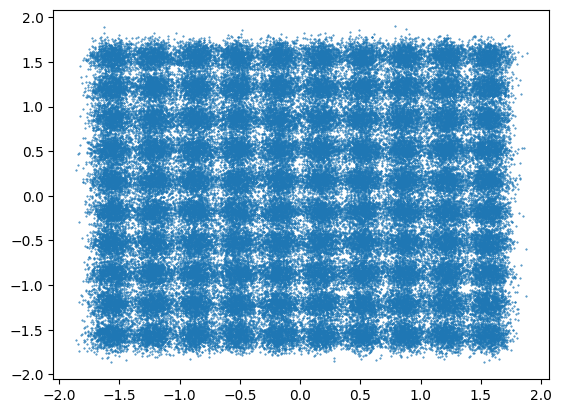

Dataset size: 199998 points


In [88]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/birch1.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 100
plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.show()
print(f"Dataset size: {data.size} points")

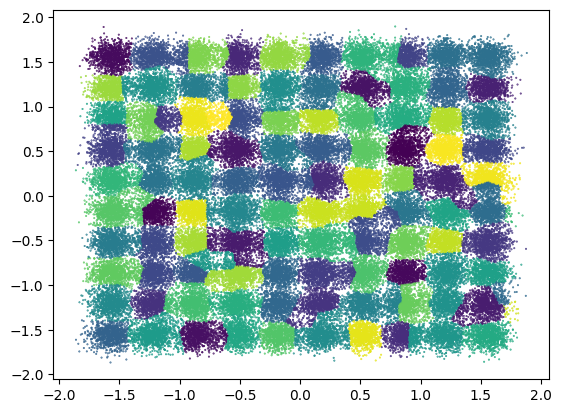

In [ ]:
birch = Birch(threshold=0.1, branching_factor=50, leaf_size=50, cluster_method='kmeans')
labels = birch.fit_predict(data, n_clusters=true_k)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.title("BIRCH")

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
kmeans = KMeans(true_k, init='k-means++')
kmeans_labels = kmeans.fit_predict(data)
dbscan = DBSCAN()
dbscan_labels = dbscan.fit_predict(data)
mini_kmeans = MiniBatchKMeans(n_clusters=true_k)
mini_kmeans_labels = mini_kmeans.fit_predict(data)

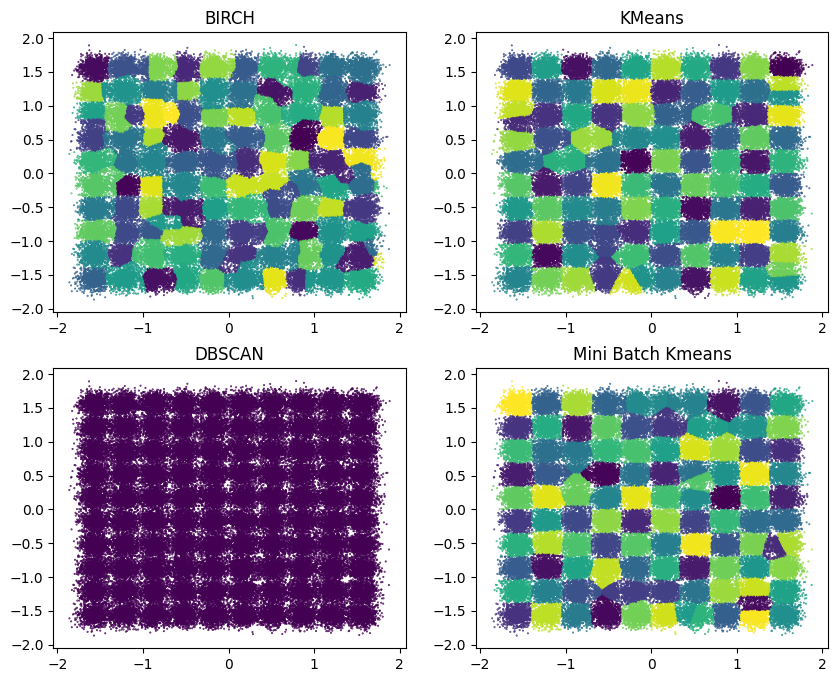

In [106]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = 0.2)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s =0.2)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s =0.2)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s =0.2)
plt.title("Mini Batch Kmeans")
plt.show()

In [ ]:
def compare_clustering_methods(data, true_k):
    birch = Birch(threshold=0.1, branching_factor=50, leaf_size=50, cluster_method='kmeans')
    labels = birch.fit_predict(data, n_clusters=true_k)
    kmeans = KMeans(true_k, init='k-means++')
    kmeans_labels = kmeans.fit_predict(data)
    dbscan = DBSCAN()
    dbscan_labels = dbscan.fit_predict(data)
    mini_kmeans = MiniBatchKMeans(n_clusters=true_k)
    mini_kmeans_labels = mini_kmeans.fit_predict(data)
    return labels, kmeans_labels, dbscan_labels, mini_kmeans_labels

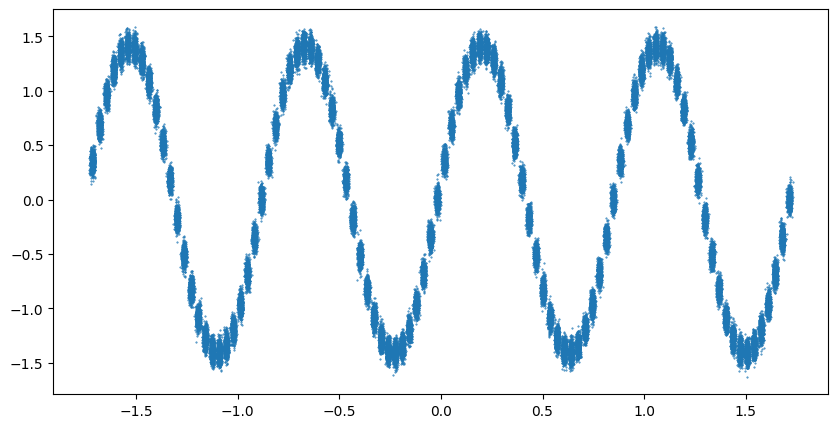

Dataset size: 199998 points


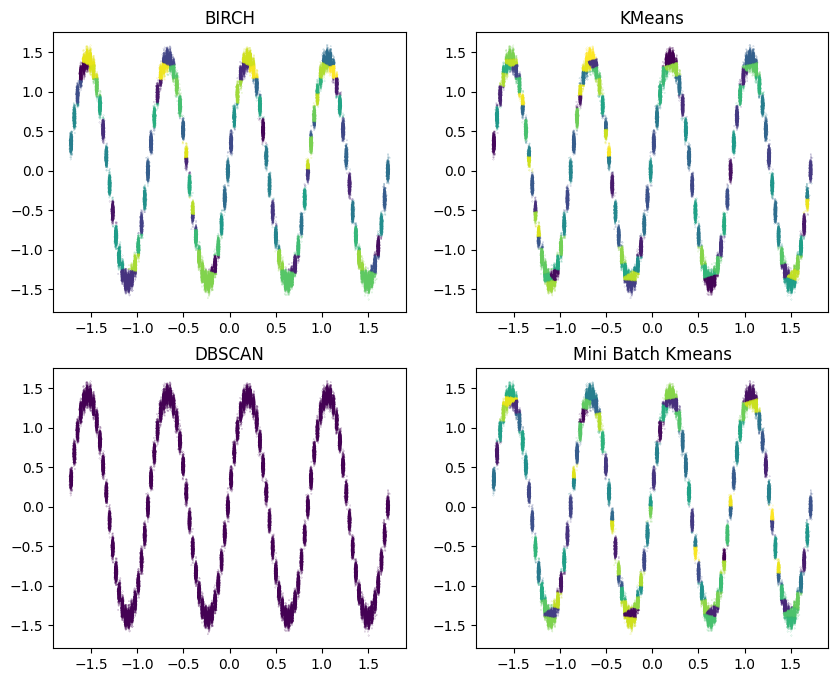

In [122]:
data = pd.read_csv('data/birch2.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 100
plt.figure(figsize=(10,5))
plt.scatter(data[:, 0], data[:, 1], s=0.2)
plt.show()
print(f"Dataset size: {data.size} points")
labels, kmeans_labels, dbscan_labels, mini_kmeans_labels = compare_clustering_methods(data, true_k)
size = 0.01
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = size)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s = size)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s = size)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s = size)
plt.title("Mini Batch Kmeans")
plt.show()

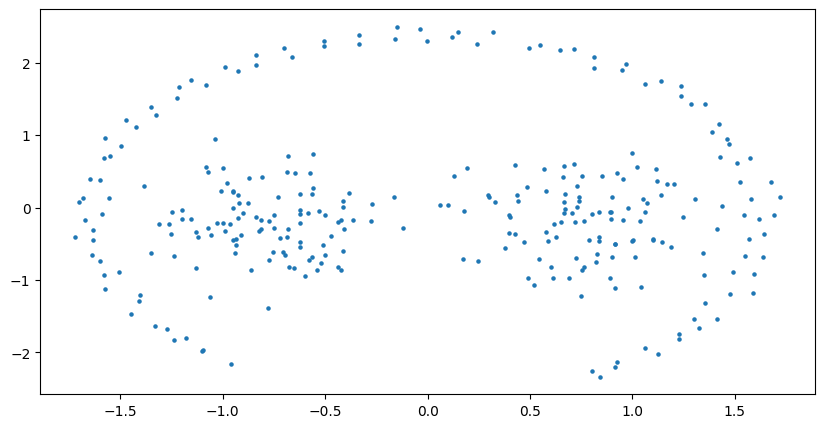

Dataset size: 897 points


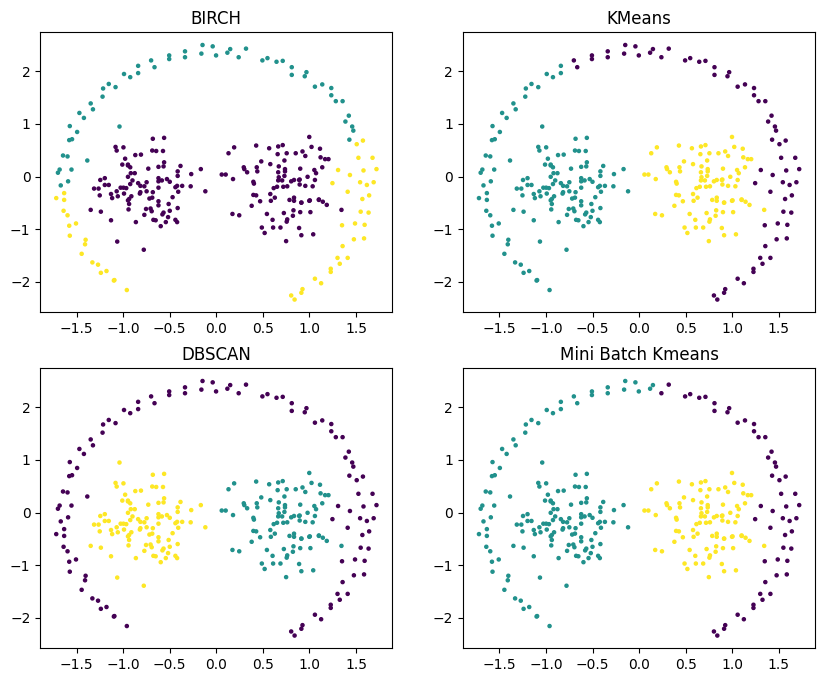

In [120]:
data = pd.read_csv('data/pathbased.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 3
size = 5
plt.figure(figsize=(10,5))
plt.scatter(data[:, 0], data[:, 1], s=size)
plt.show()
print(f"Dataset size: {data.size} points")
labels, kmeans_labels, dbscan_labels, mini_kmeans_labels = compare_clustering_methods(data, true_k)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = size)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s = size)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s = size)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s = size)
plt.title("Mini Batch Kmeans")
plt.show()

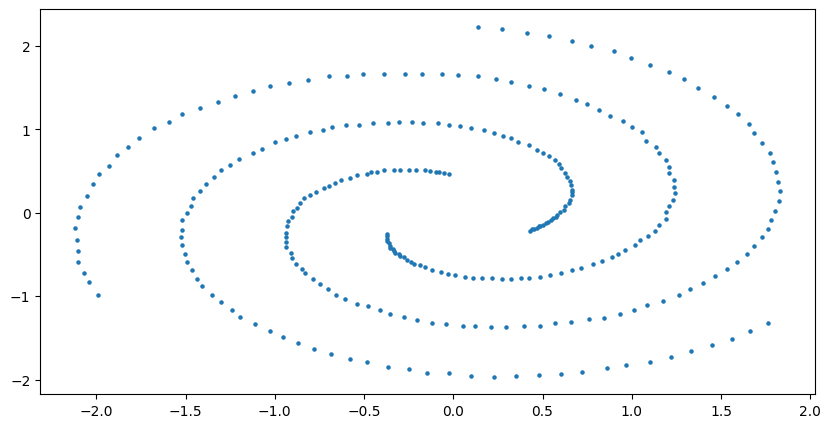

Dataset size: 933 points


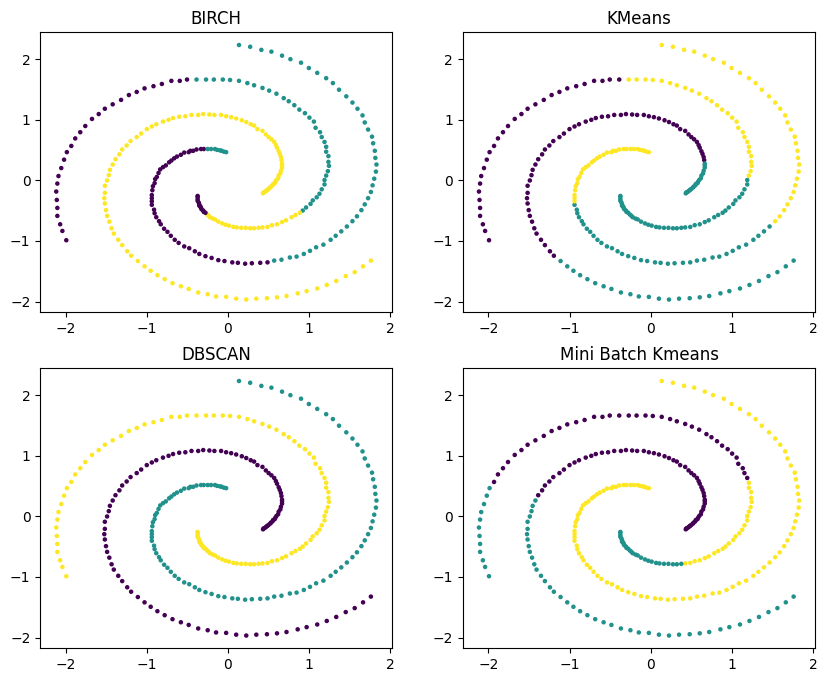

In [121]:
data = pd.read_csv('data/spiral.txt', sep=r"\s+").to_numpy()
data = (data - data.mean(0))/data.std(0)
true_k = 3
size = 5
plt.figure(figsize=(10,5))
plt.scatter(data[:, 0], data[:, 1], s=size)
plt.show()
print(f"Dataset size: {data.size} points")
labels, kmeans_labels, dbscan_labels, mini_kmeans_labels = compare_clustering_methods(data, true_k)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(data[:, 0], data[:, 1], c=labels, s = size)
plt.title("BIRCH")
plt.subplot(2,2,2)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, s = size)
plt.title("KMeans")
plt.subplot(2,2,3)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_labels, s = size)
plt.title("DBSCAN")
plt.subplot(2,2,4)
plt.scatter(data[:, 0], data[:, 1], c=mini_kmeans_labels, s = size)
plt.title("Mini Batch Kmeans")
plt.show()